# Download Data

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
src_dir = os.path.join(nb_dir, "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

from data.make_dataset import download_dataset, create_hdf

Execute `make data` or this cell first to import data.

In [2]:
# download_dataset()
# create_hdf()

# Import Data

In [3]:
import pandas as pd

df = pd.read_hdf('../data/processed/train.hdf', key='data').sample(frac=.1)

In [4]:
minDay = df["date"].min()
maxDay = df["date"].max()
print(minDay, maxDay)

1 54


In [5]:
df[:5]

id3  user_id  id2  date  id1
1619445   590  1109592   63     3    9
8065988   610   274777   12     9    9
22788221  162   186085   51    23    9
45076676  610   337137   12    51    9
33519259  741   865933   87    33    7

In [6]:
df.count()

id3        4699683
user_id    4699683
id2        4699683
date       4699683
id1        4699683
dtype: int64

# Train-Test-Split

In [7]:
train = df[df["date"] <= maxDay - 7]
test = df[df["date"] > maxDay - 7]

In [8]:
print(train["id1"].count(), test["id1"].count())

4351664 348019


In [9]:
minDayTest = test["date"].min()
maxDayTest = test["date"].max()
print(minDayTest, maxDayTest)

48 54


In [10]:
minDayTrain = train["date"].min()
maxDayTrain = train["date"].max()
print(minDayTrain, maxDayTrain)

1 47


# Create Hash Maps

In [11]:
def parentIds(df):
    id21, id32 = {}, {}
    for index, row in df.iterrows():
        if row["id2"] in id21:
            assert(id21[row["id2"]] == row["id1"])
        else:
            id21[row["id2"]] = row["id1"]
        if row["id3"] in id32:
            assert(id32[row["id3"]] == row["id2"])
        else:
            id32[row["id3"]] = row["id2"]
    return id21, id32

In [12]:
id21, id32 = parentIds(train[:10])
print(id21, id32)

{108: 4, 51: 9, 103: 8, 92: 10, 87: 7, 12: 9, 109: 9, 63: 9} {640: 109, 657: 108, 610: 12, 282: 92, 741: 87, 471: 87, 392: 92, 586: 103, 162: 51, 590: 63}


In [13]:
id21, id32 = parentIds(train)
print(len(id21), len(id32))

122 919


In [14]:
def userIds(df):
    userToId3, id3ToUser = {}, {}
    for index, row in df.iterrows():
        if not row["user_id"] in userToId3:
            userToId3[row["user_id"]] = []
        userToId3[row["user_id"]].append(row["id3"])
        if not row["id3"] in id3ToUser:
            id3ToUser[row["id3"]] = []
        id3ToUser[row["id3"]].append(row["user_id"])
    return userToId3, id3ToUser

In [15]:
userToId3, id3ToUser = userIds(train[:10])
print(userToId3, id3ToUser)

{634866: [657], 804548: [586], 186085: [162], 1109592: [590], 274777: [610], 355770: [392], 1150139: [282], 865933: [741], 476510: [640], 292565: [471]} {640: [476510], 657: [634866], 610: [274777], 282: [1150139], 741: [865933], 471: [292565], 392: [355770], 586: [804548], 162: [186085], 590: [1109592]}


In [16]:
userToId3, id3ToUser = userIds(train)
print(len(userToId3), len(id3ToUser))

585362 919


In [17]:
def userVisits(df):
    userId3Visits = {}
    for index, row in df.iterrows():
        if not row["user_id"] in userId3Visits:
            userId3Visits[row["user_id"]] = {}
        if not row["date"] in userId3Visits[row["user_id"]]:
            userId3Visits[row["user_id"]][row["date"]] = []
        userId3Visits[row["user_id"]][row["date"]].append(row["id3"])
    return userId3Visits

In [18]:
userId3Visits = userVisits(train[:10])
print(userId3Visits)

{634866: {8: [657]}, 804548: {28: [586]}, 186085: {23: [162]}, 1109592: {3: [590]}, 274777: {9: [610]}, 355770: {32: [392]}, 1150139: {20: [282]}, 865933: {33: [741]}, 476510: {34: [640]}, 292565: {20: [471]}}


In [19]:
userId3Visits = userVisits(train)
print(len(userId3Visits))

585362


In [20]:
id3s = train["id3"].unique()
print(len(id3s))

919


# Fix one Id3, look at the distribution of visits before

In [21]:
id3 = list(id3ToUser.keys())[42]
print(id3)

42


In [22]:
def profile(user, day, duration=7):
    visits = userId3Visits[user]
    id3Visited = []
    for d in range(max(0, day - duration), day):
        if d in visits:
            id3Visited += visits[d]
    return [id3Visited.count(i) for i in id3s]

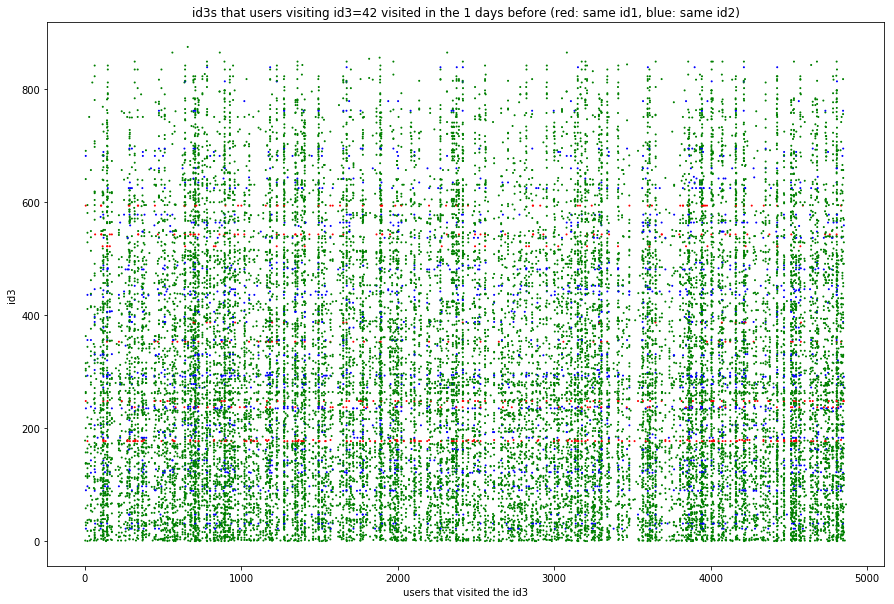

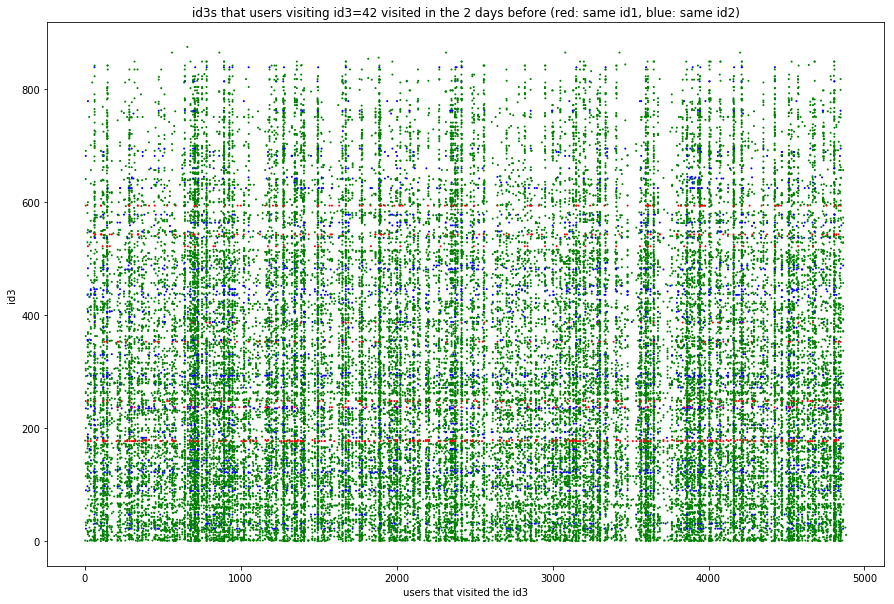

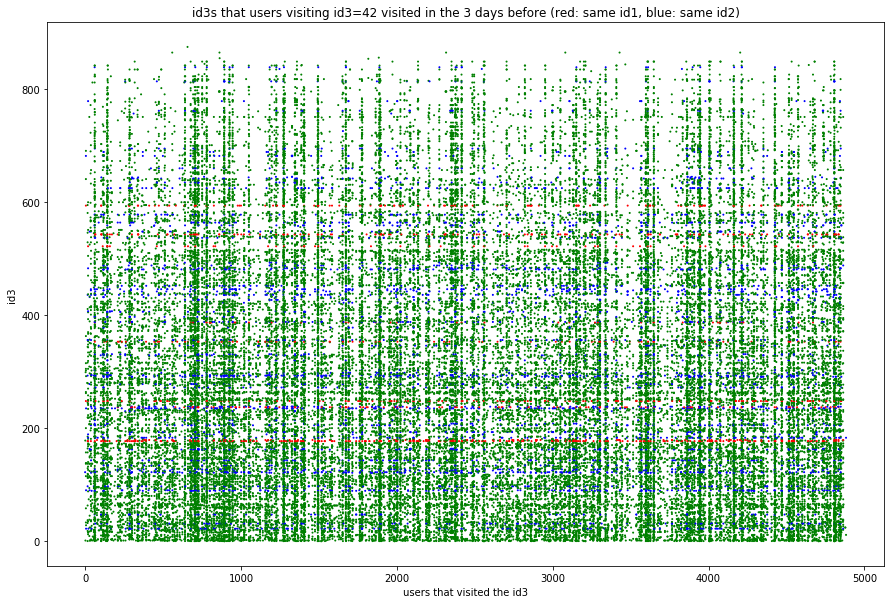

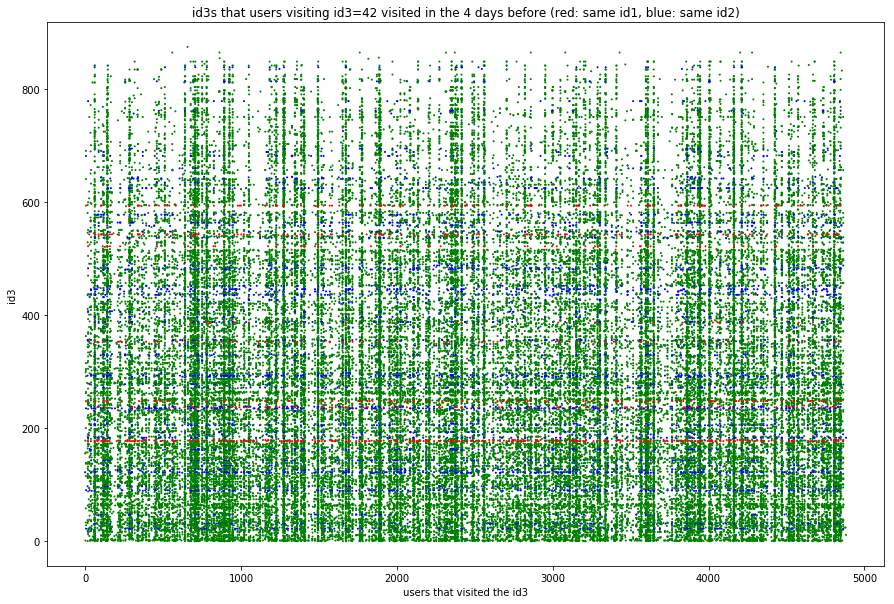

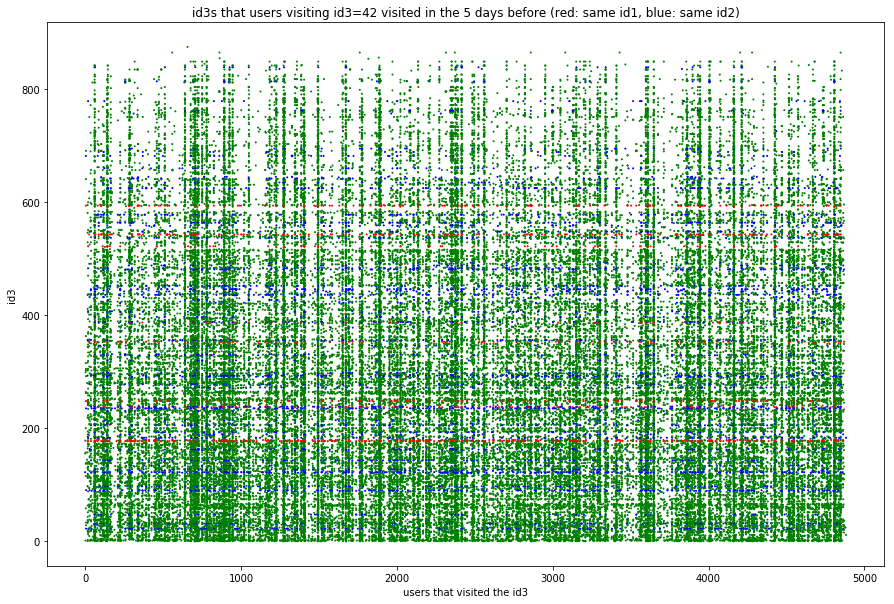

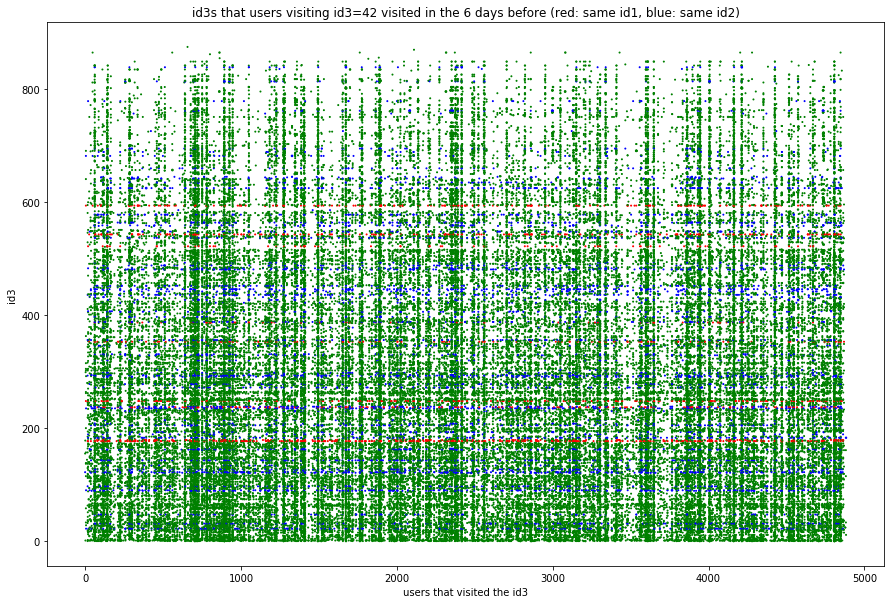

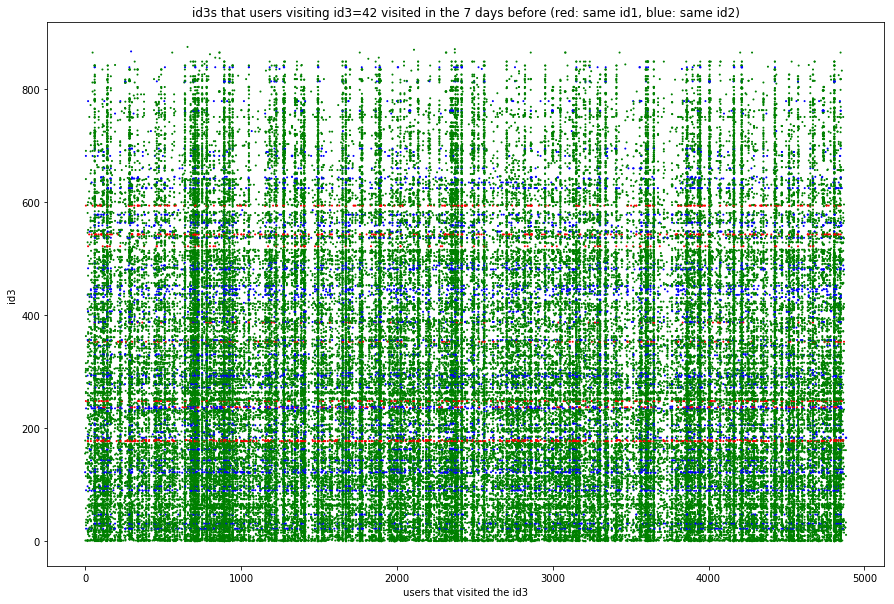

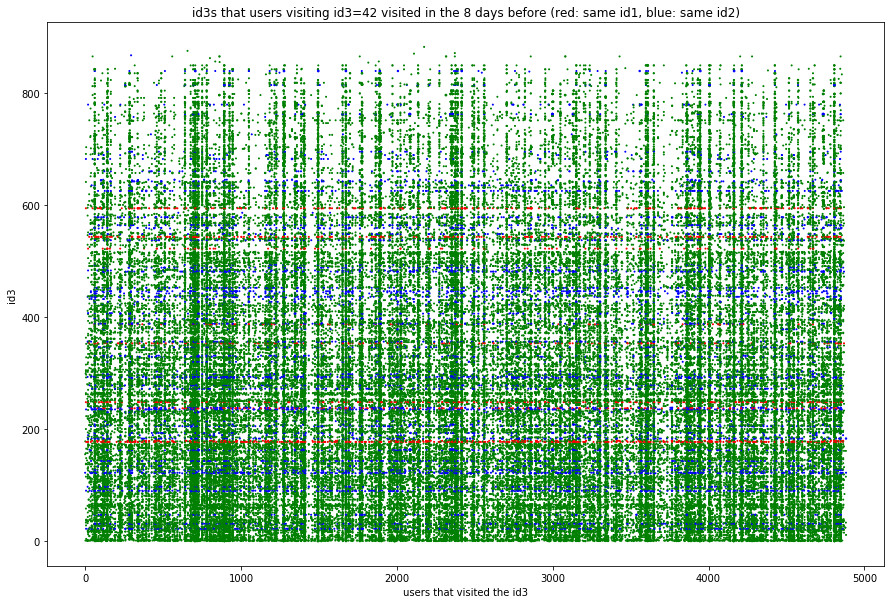

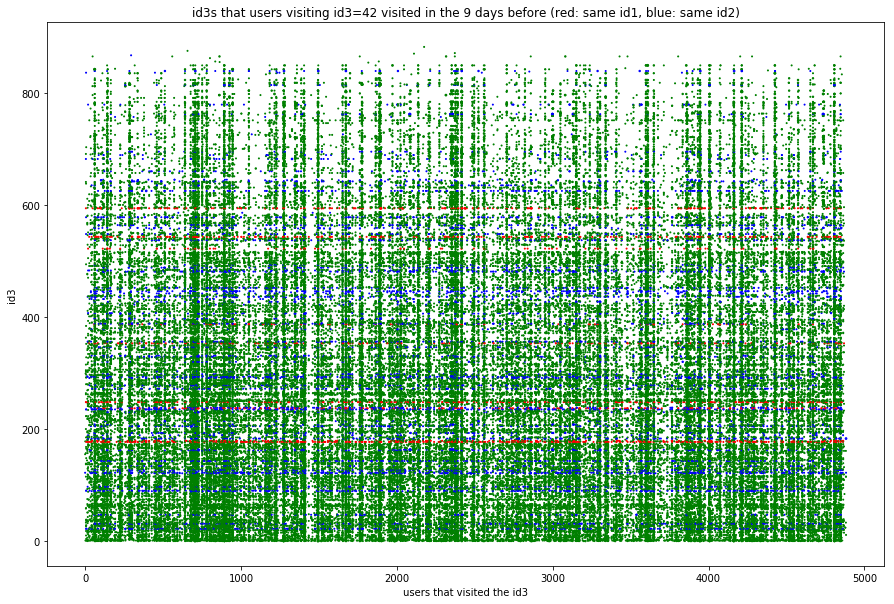

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

for duration in range(1, 10):
    X = []
    for user in id3ToUser[id3]:
        visits = userId3Visits[user]
        for day in range(minDayTrain, maxDayTrain + 1):
            if day in visits and id3 in visits[day]:
                X.append(profile(user, day, duration=duration))

    scatterx, scattery, scatters, scatterc = [], [], [], []
    for i in range(len(X)):
        for j in range(len(X[i])):
            if X[i][j]:
                scatterx.append(i)
                scattery.append(j)
                scatters.append(1 * X[i][j])
                id1Same = id21[id32[id3s[j]]] == id21[id32[id3]]
                id2Same = id32[id3s[j]] == id32[id3]
                if id2Same:
                    scatterc.append("r")
                elif id1Same:
                    scatterc.append("b")
                else:
                    scatterc.append("g")
    plt.scatter(scatterx, scattery, s=scatters, c=scatterc)
    plt.xlabel("users that visited the id3")
    plt.ylabel("id3")
    plt.title("id3s that users visiting id3={} visited in the {} days before (red: same id2, blue: same id1)".format(id3, duration))
    plt.show()